<a href="https://colab.research.google.com/github/mariohaya/key-search/blob/main/Copy_of_15a_Cluster_Political_Career_Paths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Tutorial

https://drive.google.com/drive/u/1/folders/1kHPkwKrntsdvnmU0wRulvXe_-mQ2mmgf

# Import Modules

In [1]:
# ! pip install biopython
! pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.4 MB/s eta 0:00:00


In [2]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import statsmodels.formula.api as smf
import seaborn as sns
import Levenshtein

In [ ]:
# from Bio.Align import PairwiseAligner

# Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Paths & Filenames

In [4]:
path_data = '/content/drive/MyDrive/Data Science Fundamentals/Data/'

In [5]:
os.listdir(path_data)

['Week 4 Data',
 'Week 3 wikipedia fruit',
 'employee_2.gsheet',
 'employee_2.xlsx',
 'Week 7 Data',
 'Copy of 1. All Candidates v2.xlsx',
 '2. NL Candidates.xlsx',
 '3. NL Agg Covars.xlsx',
 '2. RL Candidates.xlsx',
 'Dashboard data',
 '4. NL Agg Looker.gsheet',
 '4. NL Agg Looker.xlsx',
 'Copy of 5. Candidates_Clustered.xlsx']

In [6]:
# filenames for imported files
filename_dat = 'Copy of 1. All Candidates v2.xlsx'

# Import & Format Data

In [7]:
cand = pd.read_excel(path_data + filename_dat)

In [8]:
cand.shape

(97822, 21)

In [9]:
len(cand.NewCandID.unique())

50314

In [10]:
cand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97822 entries, 0 to 97821
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ElectionDate      97822 non-null  int64  
 1   Position          97822 non-null  object 
 2   Tier2             97822 non-null  object 
 3   ElectionDistrict  96670 non-null  object 
 4   Tier3             69430 non-null  object 
 5   Tier4             69430 non-null  object 
 6   NewCandID         97822 non-null  object 
 7   CandName          97822 non-null  object 
 8   CandSex           96720 non-null  object 
 9   CandBirthyear     97679 non-null  float64
 10  TakesOffice       97822 non-null  bool   
 11  RegionType        97822 non-null  object 
 12  PartyType         97822 non-null  object 
 13  CandEdu           73263 non-null  object 
 14  PartyName         97822 non-null  object 
 15  IsCurrent         96719 non-null  object 
 16  IsVice            89907 non-null  object

# Step 0. Encode Career Events

In [11]:
cand["RunCount"] = cand.groupby("NewCandID")["ElectionDate"].transform("count")
cand.head()

,ElectionDate,Position,Tier2,ElectionDistrict,Tier3,Tier4,NewCandID,CandName,CandSex,CandBirthyear,...,PartyType,CandEdu,PartyName,IsCurrent,IsVice,tier,branch,IsExperience,ExperienceTier,RunCount
0,20240113,總統,全國,NaN,NaN,NaN,柯文哲_1959,柯文哲,male,1959.0,...,Small Party,博士,台灣民眾黨,N,,1,Executive,False,NaN,3
1,20240113,副總統,全國,NaN,NaN,NaN,吳欣盈_1978,吳欣盈,female,1978.0,...,Small Party,碩士,台灣民眾黨,N,Y,1,Executive,False,NaN,2
2,20240113,總統,全國,NaN,NaN,NaN,賴清德_1959,賴清德,male,1959.0,...,DPP,碩士,民主進步黨,Y,,1,Executive,True,1.0,8
3,20240113,副總統,全國,NaN,NaN,NaN,蕭美琴_1971,蕭美琴,female,1971.0,...,DPP,碩士,民主進步黨,N,Y,1,Executive,True,1.0,6
4,20240113,總統,全國,NaN,NaN,NaN,侯友宜_1957,侯友宜,male,1957.0,...,KMT,博士,中國國民黨,N,,1,Executive,False,NaN,3


In [12]:
cand.Position.unique()

array(['總統', '副總統', '區域立委', '立委補選', '山地立委', '山地原住民立委', '平地立委', '平地原住民立委',
       '不分區立委', '僑選', '直轄市長', '市長補選', '縣市長', '直轄市議員（區域）', '直轄市議員（山地原住民）',
       '直轄市議員（平地原住民）', '縣市議員（區域）', '縣市議員（山地原住民）', '縣市議員（平地原住民）',
       '直轄市山地原住民區長', '鄉鎮市長', '直轄市山地原住民區民代表', '鄉鎮市民代表（區域）',
       '鄉鎮市民代表（平地原住民）', '村里長'], dtype=object)

In [13]:
cand["position_code"] = cand.Position.map({

    '總統':"NE",
    '副總統':"NE",

    '區域立委':"NL",
    '立委補選':"NL",
    '不分區立委':"NL",
    '山地原住民立委':"NL",
    '平地原住民立委':"NL",

    '僑選':pd.NA,

    '直轄市長':"RE",
    '市長補選':"RE",
    '縣市長':"RE",

    '直轄市議員（區域）':"RL",
    '直轄市議員（山地原住民）':"RL",
    '直轄市議員（平地原住民）':"RL",
    '縣市議員（區域）':"RL",
    '縣市議員（山地原住民）':"RL",
    '縣市議員（平地原住民）':"RL",

    '直轄市山地原住民區長':"DE",
    '鄉鎮市長':"DE",

    '直轄市山地原住民區民代表':"DL",
    '鄉鎮市民代表（區域）':"DL",
    '鄉鎮市民代表（平地原住民）':"DL",

    '村里長':"LE"
})

In [14]:
cand.TakesOffice.unique()

array([False,  True])

In [15]:
criteriaA = (cand["position_code"]=="NE") & (cand["TakesOffice"]==True)
criteriaB = (cand["position_code"]=="NE") & (cand["TakesOffice"]==False)

criteriaC = (cand["position_code"]=="NL") & (cand["TakesOffice"]==True)
criteriaD = (cand["position_code"]=="NL") & (cand["TakesOffice"]==False)

criteriaE = (cand["position_code"]=="RE") & (cand["TakesOffice"]==True)
criteriaF = (cand["position_code"]=="RE") & (cand["TakesOffice"]==False)

criteriaG = (cand["position_code"]=="RL") & (cand["TakesOffice"]==True)
criteriaH = (cand["position_code"]=="RL") & (cand["TakesOffice"]==False)

criteriaI = (cand["position_code"]=="DE") & (cand["TakesOffice"]==True)
criteriaJ = (cand["position_code"]=="DE") & (cand["TakesOffice"]==False)

criteriaK = (cand["position_code"]=="DL") & (cand["TakesOffice"]==True)
criteriaL = (cand["position_code"]=="DL") & (cand["TakesOffice"]==False)

criteriaM = (cand["position_code"]=="LE") & (cand["TakesOffice"]==True)
criteriaN = (cand["position_code"]=="LE") & (cand["TakesOffice"]==False)

In [16]:
cand.loc[:,"Career_Event"]=pd.NA
cand.loc[criteriaA,"Career_Event"]="A"
cand.loc[criteriaB,"Career_Event"]="B"
cand.loc[criteriaC,"Career_Event"]="C"
cand.loc[criteriaD,"Career_Event"]="D"
cand.loc[criteriaE,"Career_Event"]="E"
cand.loc[criteriaF,"Career_Event"]="F"
cand.loc[criteriaG,"Career_Event"]="G"
cand.loc[criteriaH,"Career_Event"]="H"
cand.loc[criteriaI,"Career_Event"]="I"
cand.loc[criteriaJ,"Career_Event"]="J"
cand.loc[criteriaK,"Career_Event"]="K"
cand.loc[criteriaL,"Career_Event"]="L"
cand.loc[criteriaM,"Career_Event"]="M"
cand.loc[criteriaN,"Career_Event"]="N"

In [17]:
cand.groupby("Career_Event")["NewCandID"].count()

,NewCandID
Career_Event,
A,16
B,34
C,1492
D,3057
E,166
F,454
G,6670
H,6469
I,1780


In [18]:
cand.head()

,ElectionDate,Position,Tier2,ElectionDistrict,Tier3,Tier4,NewCandID,CandName,CandSex,CandBirthyear,...,PartyName,IsCurrent,IsVice,tier,branch,IsExperience,ExperienceTier,RunCount,position_code,Career_Event
0,20240113,總統,全國,NaN,NaN,NaN,柯文哲_1959,柯文哲,male,1959.0,...,台灣民眾黨,N,,1,Executive,False,NaN,3,NE,B
1,20240113,副總統,全國,NaN,NaN,NaN,吳欣盈_1978,吳欣盈,female,1978.0,...,台灣民眾黨,N,Y,1,Executive,False,NaN,2,NE,B
2,20240113,總統,全國,NaN,NaN,NaN,賴清德_1959,賴清德,male,1959.0,...,民主進步黨,Y,,1,Executive,True,1.0,8,NE,A
3,20240113,副總統,全國,NaN,NaN,NaN,蕭美琴_1971,蕭美琴,female,1971.0,...,民主進步黨,N,Y,1,Executive,True,1.0,6,NE,A
4,20240113,總統,全國,NaN,NaN,NaN,侯友宜_1957,侯友宜,male,1957.0,...,中國國民黨,N,,1,Executive,False,NaN,3,NE,B


# Step 1. Career Sequences

In [19]:
cand2 = cand[cand.Career_Event.notna()]
cand2.shape

(95613, 24)

In [20]:
# Sort by PersonID and Timestamp
cand2 = cand2.sort_values(by=['NewCandID', 'ElectionDate'])

In [21]:
# Group by PersonID and join Event sequence
career_sequences = cand2.groupby('NewCandID')['Career_Event'].apply(lambda x: ''.join(x)).reset_index()

In [22]:
cand2["Career_Sequence"] = cand2.groupby('NewCandID')["Career_Event"].transform(lambda x: ''.join(x))
cand2 = cand2.reset_index(drop=True)
cand2.head()

,ElectionDate,Position,Tier2,ElectionDistrict,Tier3,Tier4,NewCandID,CandName,CandSex,CandBirthyear,...,IsCurrent,IsVice,tier,branch,IsExperience,ExperienceTier,RunCount,position_code,Career_Event,Career_Sequence
0,20020126,縣市議員（區域）,雲林縣,第06選舉區,NaN,NaN,_nan,,male,NaN,...,N,NaN,2,Legislative,False,NaN,1,RL,H,H
1,20100612,村里長,雲林縣,雲林縣,水林鄉,春埔村,吳忠華_1947,吳忠華,male,1947.0,...,N,,4,Executive,False,NaN,1,LE,N,N
2,20100612,村里長,雲林縣,雲林縣,口湖鄉,口湖村,李錦秀_1957,李錦秀,female,1957.0,...,N,,4,Executive,True,4.0,1,LE,M,M
3,20100612,鄉鎮市民代表（區域）,雲林縣,第02選舉區,NaN,NaN,洪順河_1945,洪順河,male,1945.0,...,Y,,3,Legislative,True,3.0,1,DL,K,K
4,20100612,村里長,嘉義縣,嘉義縣,民雄鄉,豊收村,陳文彬_1956,陳文彬,male,1956.0,...,N,,4,Executive,False,NaN,1,LE,N,N


In [23]:
# career_sequences = cand2.groupby('NewCandID').agg(
#     Career_Sequence = ('Career_Event',lambda x: ''.join(x))
# ).reset_index()

In [24]:
career_sequences = cand2[["NewCandID","Career_Sequence"]]

In [25]:
career_sequences.head(100)

,NewCandID,Career_Sequence
0,_nan,H
1,吳忠華_1947,N
2,李錦秀_1957,M
3,洪順河_1945,K
4,陳文彬_1956,N
...,...,...
95,丁文祥_1952,MM
96,丁文祥_1952,MM
97,丁旭懋_1980,LL
98,丁旭懋_1980,LL


# Step 1.5 - OPTIONAL - Filter

In [26]:
# career_sequences

In [27]:
# career_sequences["Length"] = career_sequences.apply(lambda x: len(x["Career_Sequence"]),axis=1)

In [28]:
# career_sequences.head()

In [29]:
# career_sequences.groupby("Length")["NewCandID"].count()

In [30]:
# # OPTIONAL remove career_sequences with a single item
# min_len = 3

# print(career_sequences.shape)
# career_sequences = career_sequences[career_sequences.Career_Sequence.str.len()>=min_len].reset_index(drop=True)
# print(career_sequences.shape)

In [31]:
# career_sequences.head()

# Step 1.6 - OPTIONAL - Remove High Freq Sequences

In [32]:
# high_freq = career_sequences.groupby("Career_Sequence",as_index=False).agg(
#     Sequence_Frequency = ("NewCandID","count")
# )
# high_freq = high_freq.sort_values("Sequence_Frequency",ascending=False).reset_index(drop=False)
# high_freq.head(100)

In [33]:
# high_freq.shape

In [34]:
# high_freq_seq_list = high_freq.loc[high_freq.Sequence_Frequency>100,"Career_Sequence"]
# high_freq_seq_list

In [35]:
# career_sequences.shape

In [36]:
# # career_sequences = career_sequences[~career_sequences.Career_Sequence.isin(high_freq_seq_list)]
# career_sequences = career_sequences[career_sequences.Career_Sequence.isin(high_freq_seq_list)]
# career_sequences = career_sequences.reset_index(drop=True)
# career_sequences.shape

In [37]:
# career_sequences.head()

# Step 1.7 - OPTIONAL - Filter Out Short Seq & Remove Duplicate Sequences

In [38]:
career_sequences.loc[:,"Length"] = career_sequences.apply(lambda x: len(x["Career_Sequence"]),axis=1)

<ipython-input-38-1194108117>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  career_sequences.loc[:,"Length"] = career_sequences.apply(lambda x: len(x["Career_Sequence"]),axis=1)


In [39]:
# OPTIONAL remove career_sequences with len shorter than min_len
min_len = 3

print(career_sequences.shape)
career_sequences = career_sequences[career_sequences.Career_Sequence.str.len()>=min_len].reset_index(drop=True)
print(career_sequences.shape)

(95613, 3)
(48610, 3)


In [40]:
# select unique Career Sequences
career_sequences = career_sequences[["Career_Sequence","Length"]].drop_duplicates()
career_sequences = career_sequences.reset_index(drop=True)
career_sequences.shape

(1575, 2)

In [41]:
career_sequences.head()

,Career_Sequence,Length
0,MMMN,4
1,NNN,3
2,KKIIC,5
3,CCDCCCDF,8
4,MMMM,4


# Step 2. Distance Matrix

---



In [42]:
# # Step 2: Compute pairwise distances using PairwiseAligner
# aligner = PairwiseAligner()
# aligner.mode = 'global'

In [43]:
sequence_distance_map = {}

n = len(career_sequences)
dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):

      seq1 = career_sequences.loc[i,'Career_Sequence']
      seq2 = career_sequences.loc[j,'Career_Sequence']

      if seq2 < seq1:
        seq1 = seq2
        seq2 = career_sequences.loc[i,'Career_Sequence']

      # return pairwise distance score if it's been calculated before
      if (seq1,seq2) in sequence_distance_map:
        dist = sequence_distance_map[(seq1,seq2)]

      # otherwise, calculate the score and add it to the sequence_distance_map
      else:
        score = Levenshtein.distance(seq1,seq2)
        sequence_distance_map[(seq1,seq2)] = score

      # add the distance to the distance matrix
      dist_matrix[i, j] = score
      dist_matrix[j, i] = score

    if i%100 == 0:
      print(i,len(sequence_distance_map))

0 1574
100 153924
200 296274
300 428624
400 550974
500 663324
600 765674
700 858024
800 940374
900 1012724
1000 1075074
1100 1127424
1200 1169774
1300 1202124
1400 1224474
1500 1236824


In [44]:
dist_matrix_backup = dist_matrix.copy()

In [45]:
dist_matrix = dist_matrix_backup.copy()

In [46]:
dist_matrix[0:20,0:20]

array([[0., 3., 5., 8., 1., 3., 5., 2., 5., 1., 4., 3., 4., 1., 2., 4.,
        1., 5., 4., 4.],
       [3., 0., 5., 8., 4., 3., 5., 3., 5., 3., 4., 3., 4., 2., 1., 3.,
        2., 5., 3., 3.],
       [5., 5., 0., 7., 5., 4., 5., 5., 4., 5., 4., 5., 3., 5., 5., 5.,
        5., 5., 5., 5.],
       [8., 8., 7., 0., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
        8., 8., 8., 6.],
       [1., 4., 5., 8., 0., 3., 5., 1., 5., 1., 4., 4., 4., 2., 3., 4.,
        2., 5., 4., 4.],
       [3., 3., 4., 8., 3., 0., 5., 3., 4., 2., 2., 3., 3., 3., 3., 3.,
        3., 4., 3., 3.],
       [5., 5., 5., 8., 5., 5., 0., 5., 5., 5., 5., 4., 5., 5., 5., 5.,
        5., 5., 2., 5.],
       [2., 3., 5., 8., 1., 3., 5., 0., 5., 1., 4., 4., 4., 2., 2., 4.,
        1., 5., 4., 4.],
       [5., 5., 4., 8., 5., 4., 5., 5., 0., 5., 2., 5., 3., 5., 5., 3.,
        5., 5., 5., 5.],
       [1., 3., 5., 8., 1., 2., 5., 1., 5., 0., 4., 4., 4., 1., 2., 3.,
        2., 5., 3., 3.],
       [4., 4., 4., 8., 4., 2.

# Step 3a. Hierarchical Clustering

In [47]:
# Step 3: Hierarchical clustering

# Convert to condensed distance matrix for linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [48]:
# Ensure symmetry and zero diagonal (optional cleanup)
dist_matrix = (dist_matrix + dist_matrix.T) / 2
np.fill_diagonal(dist_matrix, 0)
# dist_matrix[dist_matrix < 0] = 0

# Convert to condensed format
condensed_dist = squareform(dist_matrix)

In [49]:
# linked = linkage(condensed_dist, method='ward')
linked = linkage(condensed_dist, method='average')

In [50]:
linked.shape

(1574, 4)

# Step 3b. Agglomerative Clustering

In [51]:
# # Step 3: Agglomerative clustering

# # Agglomerative Clustering
# from sklearn.cluster import AgglomerativeClustering

In [52]:
# dist_matrix

In [53]:
# # Ensure symmetry and zero diagonal (optional cleanup)
# dist_matrix = (dist_matrix + dist_matrix.T) / 2
# np.fill_diagonal(dist_matrix, 0)
# # dist_matrix[dist_matrix < 0] = 0

# # Convert to condensed format
# # condensed_dist = squareform(dist_matrix)

In [54]:
# # Important: use precomputed distances
# model = AgglomerativeClustering(
#     n_clusters=3,
#     metric='precomputed',
#     linkage='average'  # or 'complete'
# )

# labels = model.fit_predict(dist_matrix)

In [55]:
# type(labels)

In [56]:
# career_sequences.head()

In [57]:
# labels

In [58]:
# temp = pd.DataFrame({'sequence': career_sequences.Career_Sequence, 'cluster': labels})
# top_per_cluster = (
#     temp.groupby('cluster')['sequence']
#     .value_counts()
#     .groupby(level=0)
#     .head(20)
# )

# print(top_per_cluster)

# Step 4. Plot Dendrogram

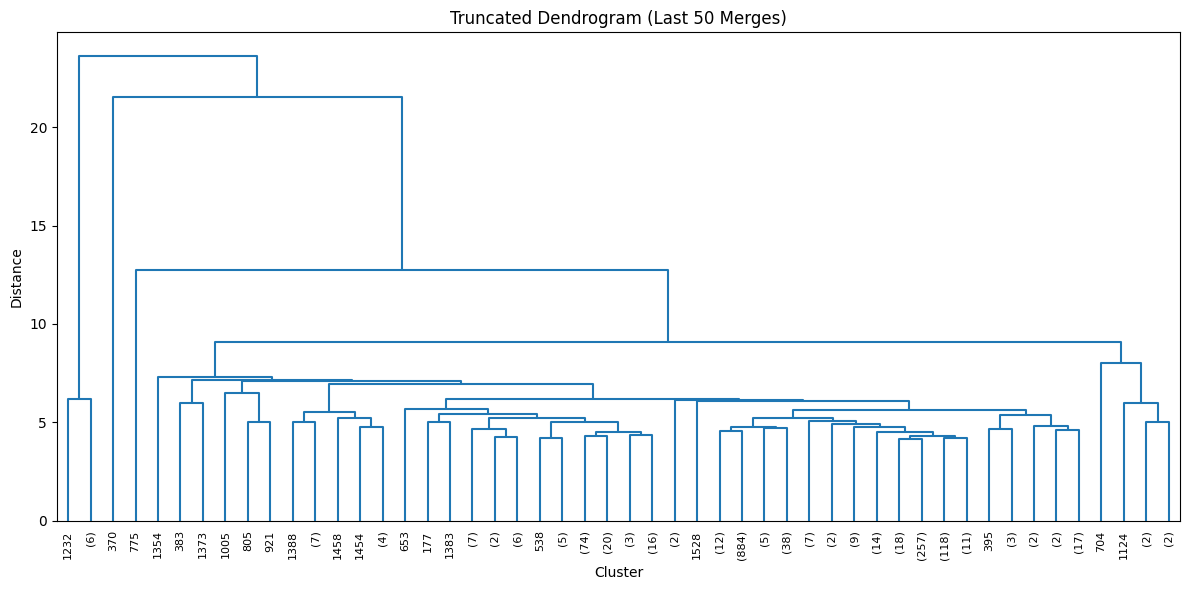

In [59]:
# Step 4: Plot dendrogram
p_nodes = 50

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=p_nodes, show_leaf_counts=True,color_threshold=False)
plt.title("Truncated Dendrogram (Last "+str(p_nodes)+" Merges)")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Step 5. Cut the Dendrogram

## k=3

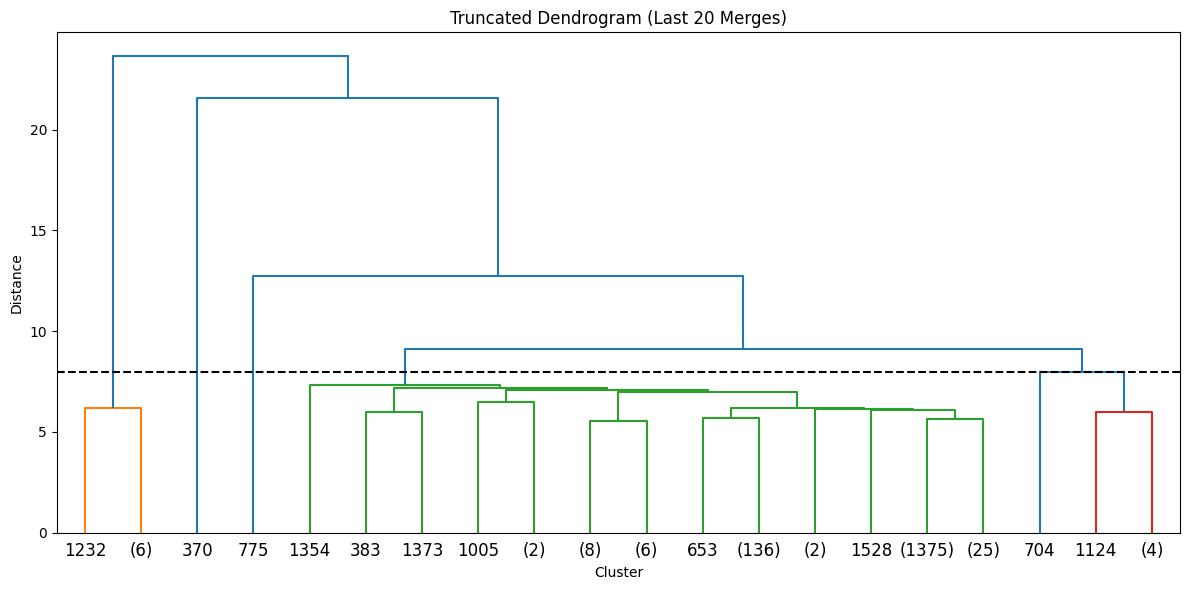

In [60]:
# Get exactly k clusters
max_clusters = 3
# threshold = linked[-(max_clusters - 1), 2]
threshold = 8
beneath_threshold = 0

# Step 4: Plot dendrogram
p_nodes = 20

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=p_nodes, show_leaf_counts=True,color_threshold=threshold)
plt.axhline(y=(threshold-beneath_threshold), c='k', ls='--', label='Cut for 3 clusters')
plt.title("Truncated Dendrogram (Last "+str(p_nodes)+" Merges)")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

## k=12

6.188438747001994


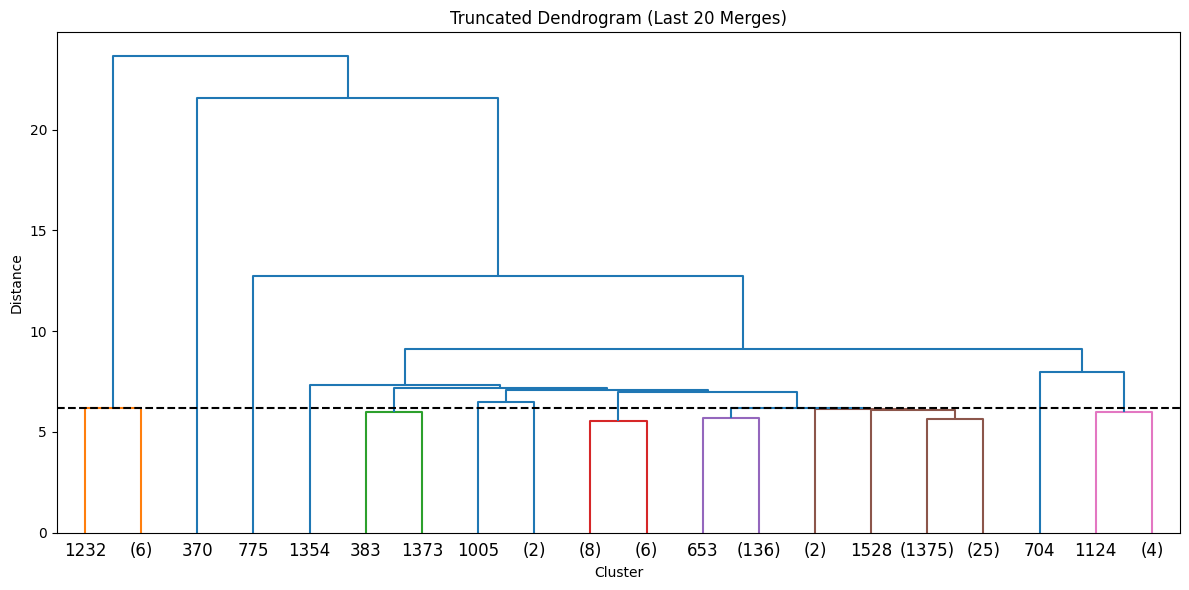

In [61]:
# Get exactly k clusters
max_clusters = 12
threshold = linked[-(max_clusters - 1), 2]
print(threshold)
# threshold = 6.5
# beneath_threshold = 0

# Step 4: Plot dendrogram
p_nodes = 20

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=p_nodes, show_leaf_counts=True,color_threshold=threshold)
plt.axhline(y=(threshold-beneath_threshold), c='k', ls='--', label='Cut for 3 clusters')
plt.title("Truncated Dendrogram (Last "+str(p_nodes)+" Merges)")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Step 6. Preliminary Sequence Analysis

In [62]:
# criteriaA = (cand["position_code"]=="NE") & (cand["TakesOffice"]==True)
# criteriaB = (cand["position_code"]=="NE") & (cand["TakesOffice"]==False)

# criteriaC = (cand["position_code"]=="NL") & (cand["TakesOffice"]==True)
# criteriaD = (cand["position_code"]=="NL") & (cand["TakesOffice"]==False)

# criteriaE = (cand["position_code"]=="RE") & (cand["TakesOffice"]==True)
# criteriaF = (cand["position_code"]=="RE") & (cand["TakesOffice"]==False)

# criteriaG = (cand["position_code"]=="RL") & (cand["TakesOffice"]==True)
# criteriaH = (cand["position_code"]=="RL") & (cand["TakesOffice"]==False)

# criteriaI = (cand["position_code"]=="DE") & (cand["TakesOffice"]==True)
# criteriaJ = (cand["position_code"]=="DE") & (cand["TakesOffice"]==False)

# criteriaK = (cand["position_code"]=="DL") & (cand["TakesOffice"]==True)
# criteriaL = (cand["position_code"]=="DL") & (cand["TakesOffice"]==False)

# criteriaM = (cand["position_code"]=="LE") & (cand["TakesOffice"]==True)
# criteriaN = (cand["position_code"]=="LE") & (cand["TakesOffice"]==False)

In [63]:
analyze_sequences = career_sequences.copy()

In [64]:
# save cluster labels
print(max_clusters)
labels = fcluster(linked, t=max_clusters, criterion='maxclust')
analyze_sequences["k_labels"]=labels

12


In [65]:
sequence_counts = analyze_sequences.groupby("k_labels",as_index=False)["Career_Sequence"].count()
sequence_counts.columns = ["k_labels","Sequence_Count"]
sequence_counts

,k_labels,Sequence_Count
0,1,7
1,2,2
2,3,2
3,4,1
4,5,14
5,6,137
6,7,1403
7,8,1
8,9,5
9,10,1


## Singletons

In [66]:
singletons = sequence_counts.loc[sequence_counts.Sequence_Count==1,"k_labels"]
singletons

,k_labels
3,4
7,8
9,10
10,11
11,12


In [67]:
# singleton Career_Sequences
analyze_sequences[analyze_sequences.k_labels.isin(singletons)]

,Career_Sequence,Length,k_labels
370,CCCCCCCCCCCCCCCCCCCCCC,22,12
704,GDCCDIDIDJJ,11,10
775,HDFHDDHDHFDDHD,14,11
1005,HGGGGMHMH,9,4
1354,JJJJLJMN,8,8


## Main Clusters

In [68]:
analyze_sequences = analyze_sequences[~analyze_sequences.k_labels.isin(singletons)]
analyze_sequences.groupby("k_labels",as_index=False)["Career_Sequence"].count()

,k_labels,Career_Sequence
0,1,7
1,2,2
2,3,2
3,5,14
4,6,137
5,7,1403
6,9,5


In [69]:
analyze_sequences.k_labels = analyze_sequences.k_labels.map({
    1:"yellow",   # 13 sequences
    4:"green",    # 148 sequences
    5:"red",      # 1185 sequences
    6:"purple",   # 218 sequences
    7:"blue"      # 8 sequences
})

<ipython-input-69-2577418873>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyze_sequences.k_labels = analyze_sequences.k_labels.map({


### Yellow (13)

In [70]:
# District & Local Execs
analyze_sequences[analyze_sequences.k_labels=="yellow"]

,Career_Sequence,Length,k_labels
551,GDDDDDDDDDDDDDDDDDDDDDDG,24,yellow
591,DDDDDDDDDDDDDDDDDDDDDDD,23,yellow
838,DDDDDDDDDDDDDDDDDDDDDD,22,yellow
934,GGHGDDDDDDDDDDDDDDDDDDDDDD,26,yellow
1040,HGDDDDDDDDDDDDDDDDDDDDDDG,25,yellow
1232,HGGHDDDDDDDDDDDDDDDDDDDDDDHHL,29,yellow
1290,DDDDDDDDDDDDDDDDDDDDDDJ,23,yellow


### Green (148)

In [71]:
# Serial NL & RE Winners
analyze_sequences[analyze_sequences.k_labels=="green"]

,Career_Sequence,Length,k_labels


### Purple (218)

In [72]:
# Serial Winner of RL races
analyze_sequences[analyze_sequences.k_labels=="purple"]

,Career_Sequence,Length,k_labels
3,CCDCCCDF,8,purple
49,FCCCD,5,purple
82,CCCC,4,purple
99,DCCCD,5,purple
116,CFCEECC,7,purple
...,...,...,...
1512,GCCCCEE,7,purple
1529,CCCEEEE,7,purple
1531,DNCFF,5,purple
1536,CCCCCFCCD,9,purple


### Blue (8)

In [73]:
# Serial losers of NL, RE races
analyze_sequences[analyze_sequences.k_labels=="blue"]

,Career_Sequence,Length,k_labels
0,MMMN,4,blue
1,NNN,3,blue
2,KKIIC,5,blue
4,MMMM,4,blue
5,HKM,3,blue
...,...,...,...
1570,KJLK,4,blue
1571,GDJDJ,5,blue
1572,DHF,3,blue
1573,MNKN,4,blue


### Red (1185)

In [74]:
# Everything else
analyze_sequences[analyze_sequences.k_labels=="red"]

,Career_Sequence,Length,k_labels
809,MMMMMKM,7,red
1154,MMNMMNM,7,red
1370,MMMMMMM,7,red
1388,MMNKNLN,7,red
1399,MMMMMMMN,8,red
1436,MKMKMKM,7,red
1442,KNKMKNJM,8,red
1454,KKKKKKKK,8,red
1457,KNMKNKN,7,red
1458,HKMMKMKMIM,10,red


# Step 7. Join Cluster Labels to Cand

In [75]:
analyze_sequences.head()

,Career_Sequence,Length,k_labels
0,MMMN,4,blue
1,NNN,3,blue
2,KKIIC,5,blue
3,CCDCCCDF,8,purple
4,MMMM,4,blue


In [76]:
# Step 6: Add cluster labels to sequences and merge with original df
cand_k = cand2.merge(analyze_sequences, on='Career_Sequence',how="inner",indicator=True)
cand_k.shape

(48436, 28)

In [77]:
# confirm the number of unique sequences
len(career_sequences.Career_Sequence.unique())

1575

In [78]:
# confirm all rows are labeled (should be guaranteed because we used an inner join)
cand_k[cand_k.k_labels.isna()]

,ElectionDate,Position,Tier2,ElectionDistrict,Tier3,Tier4,NewCandID,CandName,CandSex,CandBirthyear,...,branch,IsExperience,ExperienceTier,RunCount,position_code,Career_Event,Career_Sequence,Length,k_labels,_merge
5416,19941203,直轄市議員（區域）,臺北市,第06選舉區,NaN,NaN,周柏雅_1959,周柏雅,male,1959.0,...,Legislative,True,2.0,10,RL,G,GGDGGDDGGH,10,NaN,both
5417,19981205,直轄市議員（區域）,臺北市,第06選舉區,NaN,NaN,周柏雅_1959,周柏雅,male,1959.0,...,Legislative,True,2.0,10,RL,G,GGDGGDDGGH,10,NaN,both
5418,20011201,區域立委,臺北市,第02選舉區,第02選舉區,第02選舉區,周柏雅_1959,周柏雅,male,1959.0,...,Legislative,False,NaN,10,NL,D,GGDGGDDGGH,10,NaN,both
5419,20021217,直轄市議員（區域）,臺北市,第06選舉區,NaN,NaN,周柏雅_1959,周柏雅,male,1959.0,...,Legislative,True,2.0,10,RL,G,GGDGGDDGGH,10,NaN,both
5420,20061209,直轄市議員（區域）,臺北市,第06選舉區,NaN,NaN,周柏雅_1959,周柏雅,male,1959.0,...,Legislative,True,2.0,10,RL,G,GGDGGDDGGH,10,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47358,20141129,直轄市議員（區域）,臺北市,第02選舉區,NaN,NaN,黃珊珊_1969,黃珊珊,female,1969.0,...,Legislative,True,2.0,10,RL,G,GGGGDGDGFC,10,NaN,both
47359,20160116,區域立委,臺北市,第04選舉區,第04選舉區,第04選舉區,黃珊珊_1969,黃珊珊,female,1969.0,...,Legislative,False,NaN,10,NL,D,GGGGDGDGFC,10,NaN,both
47360,20181124,直轄市議員（區域）,臺北市,第02選舉區,NaN,NaN,黃珊珊_1969,黃珊珊,female,1969.0,...,Legislative,True,2.0,10,RL,G,GGGGDGDGFC,10,NaN,both
47361,20221126,直轄市長,臺北市,臺北市,臺北市,臺北市,黃珊珊_1969,黃珊珊,female,1969.0,...,Executive,False,NaN,10,RE,F,GGGGDGDGFC,10,NaN,both


In [79]:
# drop the _merge column, if there is one
if "_merge" in cand_k.columns: cand_k = cand_k.drop(columns=["_merge"])

In [80]:
cand_k.head()

,ElectionDate,Position,Tier2,ElectionDistrict,Tier3,Tier4,NewCandID,CandName,CandSex,CandBirthyear,...,tier,branch,IsExperience,ExperienceTier,RunCount,position_code,Career_Event,Career_Sequence,Length,k_labels
0,20101127,村里長,臺南市,臺南市,安定區,保西里,丁主亮_1961,丁主亮,male,1961.0,...,4,Executive,True,4.0,4,LE,M,MMMN,4,blue
1,20141129,村里長,臺南市,臺南市,安定區,保西里,丁主亮_1961,丁主亮,male,1961.0,...,4,Executive,True,4.0,4,LE,M,MMMN,4,blue
2,20181124,村里長,臺南市,臺南市,安定區,安加里,丁主亮_1961,丁主亮,male,1961.0,...,4,Executive,True,4.0,4,LE,M,MMMN,4,blue
3,20221126,村里長,臺南市,臺南市,安定區,安加里,丁主亮_1961,丁主亮,male,1961.0,...,4,Executive,False,NaN,4,LE,N,MMMN,4,blue
4,20100612,村里長,嘉義縣,嘉義縣,義竹鄉,東榮村,丁勝義_1944,丁勝義,male,1944.0,...,4,Executive,True,4.0,4,LE,M,MMMN,4,blue


## Export